In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt


from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
import keras.backend as K
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
X_training = pickle.load(open("../data/X_train.pickle","rb"))
Y_training = pickle.load(open("../data/Y_train.pickle","rb"))
X_testing = pickle.load(open("../data/X_test.pickle","rb"))
Y_testing = pickle.load(open("../data/Y_test.pickle","rb"))

X_training_un = pickle.load(open("../data/X_train_un.pickle","rb"))
Y_training_un = pickle.load(open("../data/Y_train_un.pickle","rb"))
X_testing_un = pickle.load(open("../data/X_test_un.pickle","rb"))
Y_testing_un = pickle.load(open("../data/Y_test_un.pickle","rb"))

X_training = np.concatenate((X_training, X_training_un), axis=0)
Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
X_testing = np.concatenate((X_testing, X_testing_un), axis=0)
Y_testing = np.concatenate((Y_testing, Y_testing_un), axis=0)

# Centering
mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_testing = (X_testing - mux)/stdx

In [3]:
data_dir = '../data2/S7_D100_ush'

X_training = np.load(os.path.join(data_dir, "X_train.npy"))
Y_training = np.load(os.path.join(data_dir, "Y_train.npy"))

X_val = np.load(os.path.join(data_dir, "X_val.npy"))
Y_val = np.load(os.path.join(data_dir, "Y_val.npy"))

X_testing = np.load(os.path.join(data_dir, "X_test.npy"))
Y_testing = np.load(os.path.join(data_dir, "Y_test.npy"))

# Centering and Normalizing data

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

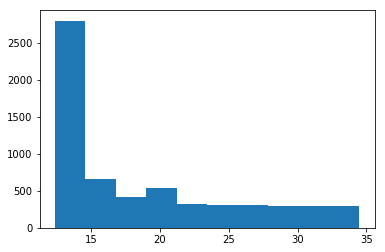

In [4]:
plt.hist(Y_training)
plt.show()

In [3]:
def get_model(time_steps = 30, data_dim = 50):
    in_neurons = 50
    out_neurons= 1
    hidden_neurons = 20
    
    # model = Sequential()
    # model.add(LSTM(hidden_neurons, input_shape=(time_steps, data_dim), return_sequences=True, activation="relu"))
    # # model.add(Flatten())
    # model.add(LSTM(25, return_sequences=False, activation="relu"))
    # model.add(Dense(out_neurons, input_shape = (time_steps, hidden_neurons), activation="linear"))
    # # model.add(Activation("linear"))
    # nadam = Nadam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    # model.compile(loss="mean_squared_error", optimizer=nadam)
    # L=len(X_training)

    layer1Dim = 100
    layer2Dim = 50
    inputs = Input(shape=(time_steps, data_dim))
#     batchNorm1 = BatchNormalization( name = "batch_norm_1")(inputs)
    lstm1 = LSTM(layer1Dim, return_sequences = True, name = 'lstm_1', activation="tanh")(inputs)
    batchNorm2 = BatchNormalization( name = "batch_norm_2")(lstm1)
    lstm2 = LSTM(layer2Dim, return_sequences = False, name = 'lstm_2', activation="relu")(batchNorm2)
    # flatten = Flatten()(lstm1)
    output = Dense(1, activation='linear')(lstm2)
    model = Model(inputs = inputs, outputs = output)
    
    return model   

In [8]:
def get_model2(data_dim = 50):
    model = Sequential()
    model.add(Dense(input_shape=(data_dim,), output_dim=256))
    model.add(Activation("tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(output_dim=1))   
    return model

In [4]:
def create_dataset(X, Y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_steps-1):
        a = X[i:(i+time_steps)]
        dataX.append(a)
        a = Y[(i+time_steps)]
        dataY.append(a)  #dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
time_steps = 30
trainX, trainY = create_dataset(X_training, Y_training, time_steps)
# valX, valY = create_dataset(X_val, Y_val, time_steps)
testX, testY = create_dataset(X_testing, Y_testing, time_steps)

In [6]:
print(X_training.shape, Y_training.shape)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1890, 50) (1890,)
(1859, 30, 50) (1859,)
(779, 30, 50) (779,)


In [35]:
# # Training
# n_epochs = 20
# time_steps = 5
# data_dim = X_training.shape[1]
# rmses = np.zeros((time_steps, n_epochs))
# optimizer = optimizers.RMSprop(lr=1e-5)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)

# for time_step in range(1,time_steps+1):
#     model = get_model(time_steps, data_dim)
#     model.compile(loss="mean_squared_error", optimizer=optimizer)
#     for i in range(n_epochs):
#         for j in range(L-time_steps):
#             X_train = np.reshape(X_training[j:j+time_steps,:], [1, time_steps, data_dim])
#             Y_train = np.reshape(Y_training[j+time_steps], [1, 1])
#             model.fit(X_train, Y_train, verbose=0, epochs=1)
#         rmse = get_rmse(model, X_testing, Y_testing, time_steps)
#         print("Time-Step {}/{} \t Epoch {}/{} \t RMSE = {}".format(time_step, time_steps, i+1, n_epochs, rmse))
#         rmses[time_step-1, i] = rmse
# #     print("Time Step {} done".format(time_step))

In [7]:
n_epochs = 50
data_dim = X_training.shape[1]
optimizer = optimizers.RMSprop(lr=1e-4)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(time_steps, data_dim)
model.compile(loss="mean_squared_error", optimizer=optimizer)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
print(model.summary())
batch_size = 20
L=len(X_training)

# for i in range(n_epochs):
#     for j in range(0, L, batch_size):
#         X_train = np.reshape(X_training[j:j+batch_size,:], [1, batch_size, data_dim])
#         Y_train = np.reshape(Y_training[j+batch_size], [1, 1])
# val_data = (valX, valY)
val_data = (testX, testY)
# model.fit(X_training, Y_training, batch_size=batch_size, epochs=20, validation_data=val_data)
# rmse = get_rmse(model, X_testing, Y_testing, time_steps)
# print("Time-Step {}/{} \t Epoch {}/{} \t RMSE = {}".format(time_step, time_steps, i+1, n_epochs, rmse))
# rmses[time_step-1, i] = rmse

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 100)           60400     
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 30, 100)           400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,051
Trainable params: 90,851
Non-trainable params: 200
_________________________________________________________________
None


In [10]:
#model.fit(X_training, Y_training, batch_size=batch_size, epochs=50, validation_data=val_data)

model.fit(trainX, trainY, batch_size=batch_size, epochs=200, validation_data=val_data, callbacks=callbacks_list)

Train on 1859 samples, validate on 779 samples
Epoch 1/200
1859/1859 [==============================] - 15s 8ms/step - loss: 0.0086 - val_loss: 0.1548


/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:493: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0082 - val_loss: 0.1529
Epoch 3/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0091 - val_loss: 0.1585
Epoch 4/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0090 - val_loss: 0.1553
Epoch 5/200
1859/1859 [==============================] - 15s 8ms/step - loss: 0.0093 - val_loss: 0.1510
Epoch 6/200
1859/1859 [==============================] - 17s 9ms/step - loss: 0.0087 - val_loss: 0.1551
Epoch 7/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0094 - val_loss: 0.1464
Epoch 8/200
1859/1859 [==============================] - 16s 9ms/step - loss: 0.0086 - val_loss: 0.1484
Epoch 9/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0088 - val_loss: 0.1445
Epoch 10/200
1859/1859 [==============================] - 16s 8ms/step - loss: 0.0085 - val_loss: 0.1427
Epoch 11/200
1859/1859 [==============================] - 15s 8

KeyboardInterrupt: 

MSE 0.131166373993


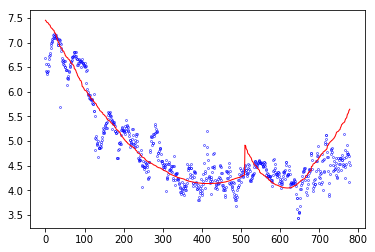

In [12]:
from sklearn.metrics import mean_squared_error
preds = model.predict(testX)
# rmse = np.sqrt(np.mean((np.array(preds) - testY)**2))
rmse = (mean_squared_error(preds, testY))
print("MSE", rmse)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(testY,'r',linewidth=1.0)
plt.show()

In [13]:
# # Save model
model.save('model_lstm_smalldata.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

In [ ]:
def get_rmse(model, X_testing, Y_testing, time_steps):
    preds=[]
    for j in range(len(X_testing)-time_steps):
        predicted = model.predict(np.reshape(X_testing[j:j+time_steps, :], [1, time_steps, X_testing.shape[1]]))
        preds.append(predicted[-1])

    Y_tst = Y_testing[time_steps:]
    rmse = np.sqrt(np.mean((np.array(preds) - Y_tst)**2))
    return rmse

In [ ]:
preds=[]
for j in range(len(X_testing)-time_steps):
    predicted = model.predict(np.reshape(X_testing[j:j+time_steps, :], [1, time_steps, X_testing.shape[1]]))
#     predicted = np.reshape(predicted, [10])
    preds.append(predicted[-1])
    
Y_tst = Y_testing[time_steps:]
rmse = np.sqrt(np.mean((np.array(preds) - Y_tst)**2))
print(rmse)

In [25]:
preds = model.predict(X_testing)

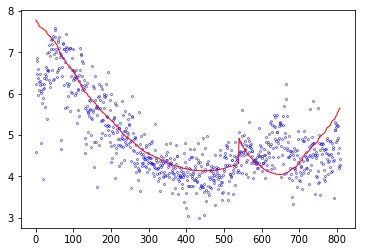

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_testing,'r',linewidth=1.0)
plt.show()

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [23]:
# model.save('mlp.h5')

In [24]:
import keras
model = keras.models.load_model('mlp.h5')